<center>
    <h1>CINECIPHER</h1>  
</center>


## Introduction

Content recommendation and optimization has long been a field that entertainment giants such as Meta, Tik Tok, and Google have been heavily invested in, constantly tweaking their recommendation algorithms in order to keep viewers watching. In my project, I create our own content recommendation algorithm which uses natural language processing to pick out movies that most closely fit what the user is looking for.

## Source of Data

The data used in this project was web scraped from IMDB film pages using the library Beautiful Soup. The program was created to perform the web scraping that scraped more than 10,000 web pages, recording information about the film such as the director, the cast, the general plot, genre, year of release, along with other miscellaneous information.

## Possible Sources of Bias

1. User-Generated Content: IMDb uses ratings, reviews, and cast information submitted by users. Hence, it represents the preferences and opinions of IMDb users, this user-contributed data may contain certain biases.

2. Self-Selection Bias: IMDb contributors may have a specific interest in movies, which may result in biases in the types of movies that are well-documented and rated on the platform.

3. Temporal Bias: The current popularity of movies may have an impact on IMDb data. The data may be skewed towards recent releases because new releases may garner more ratings and reviews than older movies.

4. Selection Bias: The movies that are featured on IMDb are typically those that have become somewhat well-known. The underrepresentation of smaller or independent films may result in a preference for mainstream and English-language films.

## These are all the libraries that I'm are using

* pandas is used for accessing, manipulating, data structure(data frame) and analyzing the data.
* nummpy is used for mathematical calculations
* spacy is used as a tool for natural language processing
* string is used to do string operations
* genim is used for topic modeling or document similarity analysis
* operator module provides functions that perform standard operations on built-in Python data types
* re module is used for regular expressions, which allow you to match and manipulate text using patterns
* time module provides time-related functions
* BeautifulSoup is a library for web scraping. It allows you to parse HTML and XML documents
* requests library is used for making HTTP requests to web servers
* WordCloud library is used to create word cloud visualizations, which show word frequency in a visually appealing way.
* Matplotlib is used for plotting
* defaultdict is a dictionary subclass that provides default values for missing keys.
* os module provides functions for interacting with the operating system, including file and directory manipulation.

In [5]:
import pandas as pd
import numpy as np
import spacy
import string
import gensim
import operator
import re
import time
from bs4 import BeautifulSoup
import requests
from gensim import corpora
from spacy.lang.en.stop_words import STOP_WORDS
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import defaultdict
from gensim.similarities import MatrixSimilarity
from operator import itemgetter
import os

## Data Acquisition

Data acquisition in the context of nlp is obtaining the raw text data from a specified source. This data can come from a variety of sources, including web scraping, document parsing, or text files.

In this project I'm collecting data on the top 500 movies from each of the 23 specified genres from the IMDb website. This data collection process will be accomplished through a combination of web scraping techniques and regular expression pattern matching.

In [6]:
# creating a list of all genres to loop over
genre_list = ['action', 'adventure', 'animation', 'biography', 'comedy', 'crime', 'documentary', 'drama', 'family',
              'fantasy', 'film-noir', 'history', 'horror', 'music', 'musical', 'mystery', 'romance', 'sci-fi',
              'short', 'sport', 'thriller', 'war', 'western']

In [7]:
# initializing the required lists needed to store all data
movie_name = []
movie_plot = []
director_list = []
stars_list = []
rating_list = []
storyline = []

In [8]:
# defining the function that scrapes the data from imdb
def get_imdb_data(url):
    global movie_name
    global movie_plot
    global director_list
    global stars_list
    global rating_list
    global storyline
    global movie_counter
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    movie_list = soup.find_all('div', class_='lister-item-content')
    for movie in movie_list:
        try:
            movie_counter += 1
            movie_name.append(movie.find('a').get_text())
            movie_ref_id = movie.find('a')['href'].split('/')[2]
            movie_plot.append(movie.find_all('p', class_= 'text-muted')[1].get_text())
            d_start = movie.find_all('p', class_= '')[0].get_text().find('Director:')
            s_start = movie.find_all('p', class_= '')[0].get_text().find('Stars:')
            director_list.append(movie.find_all('p', class_= '')[0].get_text()[15:s_start])
            stars_list.append(movie.find_all('p', class_= '')[0].get_text()[47:])
            rating_list.append(movie.find('strong').get_text())


            url_story = 'https://www.imdb.com/title/{}/plotsummary/?ref_=tt_stry_pl'.format(movie_ref_id)
            headers = {
                "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36"
            }
            response = requests.get(url_story, headers=headers)
            soup_story = BeautifulSoup(response.text, "html.parser")
            summary_object = soup_story.find_all('span', {'style': 'display:block'})
            if summary_object != []:
                storyline.append(summary_object[0].find_parent('div').get_text())
            else:
                storyline.append('')
            print('Done with movie:', movie_counter)

        except Exception as e:
            print(e)
            print('Skipping movie:', movie_name[-1])
            continue

In [9]:
# looping over every genre and scraping information for the top popular 500 movies under each genre

file_name = 'movies_cleaned_2.csv'

# Only gather the data if file is not present
if(os.path.isfile(file_name) == False):
    for genre in genre_list:
        movie_counter = 0
        for page in range(1, 11, 1):
            if movie_counter <= 50:
                url = 'https://www.imdb.com/search/title/?title_type=movie&genres={}&sort=num_votes,desc&explore=genres'.format(genre)
                get_imdb_data(url)
                print('Number of {} movies scraped:'.format(genre), movie_counter)
            else:
                url = 'https://www.imdb.com/search/title/?title_type=movie&genres={}&sort=num_votes,desc&start={}&explore=genres&ref_=adv_nxt'.format(genre, movie_counter + 1)
                get_imdb_data(url)
                print('Number of {} movies scraped:'.format(genre), movie_counter)
    # creating a dictionary with all the lists and creating a df
    data_dic = {
        'name': movie_name,
        'rating': rating_list,
        'director': director_list,
        'stars': stars_list,
        'plot': movie_plot,
        'stroyline': storyline
    }

    final_movie_df = pd.DataFrame(data_dic)
    final_movie_df.to_csv(file_name)

## Preprocessing

In the field of Natural Language Processing (NLP), text data is a valuable resource for training and evaluating machine learning models. However, raw text data often contains noise, irregularities, and unstructured content. Therefore, the following steps are performed in our project to prepare the data for NLP tasks:

These tasks are:

Data Cleaning:
Conduct data cleaning to remove any noise, irrelevant information, or formatting issues from the raw text. This step may involve:
   * Removing HTML tags, special characters, and punctuation.
   * Lowercasing all text to ensure consistency.
   * Handling missing or duplicate data points.
   * Removing stopwords (common words like "the," "and," "in") if necessary.

Tokenization:
Tokenization is the process of splitting the cleaned text into individual units called tokens. Tokens can be words, subwords, or characters, depending on the desired level of granularity. In context of this project, we are using words as tokens.

Sequence Formatting:
Convert the tokenized text into a suitable sequence format, such as lists of tokens or numerical vectors.

Data Preprocessing:
Apply further preprocessing techniques as needed for specific NLP tasks. Lemmatization is on of the process we applied in this project.

In [6]:
final_movie_df = pd.read_csv('imdb_data_all.csv')
final_movie_df.columns

Index(['Unnamed: 0', 'name', 'rating', 'director', 'stars', 'plot',
       'storyline'],
      dtype='object')

In [9]:
df_movies = final_movie_df[['name', 'rating','director','stars', 'plot', 'storyline']]
df_movies['plot'] = df_movies['plot'].str.replace("\n"," ")
df_movies['storyline'] = df_movies['storyline'].apply(lambda x: str(x).split('—')[0])
df_movies['summary'] = df_movies['plot'] + ' ' + df_movies['storyline']
df_movies = df_movies.drop(['plot','storyline'],axis=1)
df_movies['stars'] = df_movies['stars'].str.replace("\n"," ")
df_movies['stars'] = df_movies['stars'].str.replace("Stars:","")
df_movies['stars'] = df_movies['stars'].str.replace("|","")
df_movies['stars'] = df_movies['stars'].str.strip()
df_movies['summary'] = df_movies['summary'].str.strip()
df_movies['all_text'] = df_movies['director'] + df_movies['stars'] + df_movies['summary']
df_movies.to_csv('movies_cleaned_2.csv')
df_movies.columns


<ipython-input-9-82155b904095>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movies['plot'] = df_movies['plot'].str.replace("\n"," ")
<ipython-input-9-82155b904095>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movies['storyline'] = df_movies['storyline'].apply(lambda x: str(x).split('—')[0])
<ipython-input-9-82155b904095>:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as lit

Index(['name', 'rating', 'director', 'stars', 'summary', 'all_text'], dtype='object')

In [11]:
file_name = 'movies_cleaned_2.csv'
movies_df = pd.read_csv(file_name)[['name', 'rating', 'director', 'stars', 'summary', 'all_text']]

In [12]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10483 entries, 0 to 10482
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      10483 non-null  object 
 1   rating    10483 non-null  float64
 2   director  10483 non-null  object 
 3   stars     10474 non-null  object 
 4   summary   10483 non-null  object 
 5   all_text  10474 non-null  object 
dtypes: float64(1), object(5)
memory usage: 491.5+ KB


In [13]:
movies_df = movies_df.drop_duplicates(['name', 'summary'])
# We are just considering 'name' and 'all_text' as it is combination of all the necessary information from the text data
df_to_clean = movies_df.reset_index()[['name', 'all_text']]

In [14]:
df_to_clean

,name,all_text
0,The Dark Knight,"Christopher Nolan\n| \n Christian Bale, He..."
1,Inception,"Christopher Nolan\n| \n Leonardo DiCaprio, ..."
2,The Matrix,"\nLana Wachowski, \nLilly Wachowski\n| \n i..."
3,The Lord of the Rings: The Fellowship of the Ring,"Peter Jackson\n| \n ah Wood, Ian McKellen,..."
4,The Lord of the Rings: The Return of the King,"Peter Jackson\n| \n ah Wood, Viggo Mortens..."
...,...,...
5793,The Born Losers,"Tom Laughlin\n| \n aughlin, Elizabeth Jame..."
5794,Chino,"\nJohn Sturges, \nDuilio Coletti\n| \n Char..."
5795,No Man's Land,"Hao Ning\n| \n Duobujie, Nan Yu, Bo Huang..."
5796,The Oklahoma Kid,"Lloyd Bacon\n| \n Cagney, Humphrey Bogart,..."


In [15]:
spacy_nlp = spacy.load("en_core_web_sm")

In [16]:
punctuations = string.punctuation

In [17]:
stop_words = STOP_WORDS

In [18]:
def spacy_tokenizer(sentence):

    #remove distracting single quotes
    sentence = re.sub('\'','',sentence)

    #remove digits adnd words containing digits
    sentence = re.sub('\w*\d\w*','',sentence)

    #replace extra spaces with single space
    sentence = re.sub(' +',' ',sentence)

    #remove unwanted lines starting from special charcters
    sentence = re.sub(r'\n: \'\'.*','',sentence)
    sentence = re.sub(r'\n!.*','',sentence)
    sentence = re.sub(r'^:\'\'.*','',sentence)

    #remove non-breaking new line characters
    sentence = re.sub(r'\n',' ',sentence)

    #remove punctunations
    sentence = re.sub(r'[^\w\s]',' ',sentence)

    #creating token object
    tokens = spacy_nlp(sentence)

    #lower, strip and lemmatize
    tokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens]

    #remove stopwords, and exclude words less than two charecters
    tokens = [word for word in tokens if word not in stop_words and word not in punctuations and len(word) > 2]

    #return tokens
    return tokens

In [19]:
df_to_clean['all_text_tokenized'] = df_to_clean['all_text'].map(lambda x: spacy_tokenizer(str(x)))

In [20]:
# use this for any sort of visualization
pd.Series(np.concatenate(df_to_clean['all_text_tokenized'])).value_counts()

life            2474
find            2355
man             1985
new             1767
young           1669
                ... 
oakes              1
redefinition       1
lloydscott         1
orman              1
vigilantism        1
Length: 42947, dtype: int64

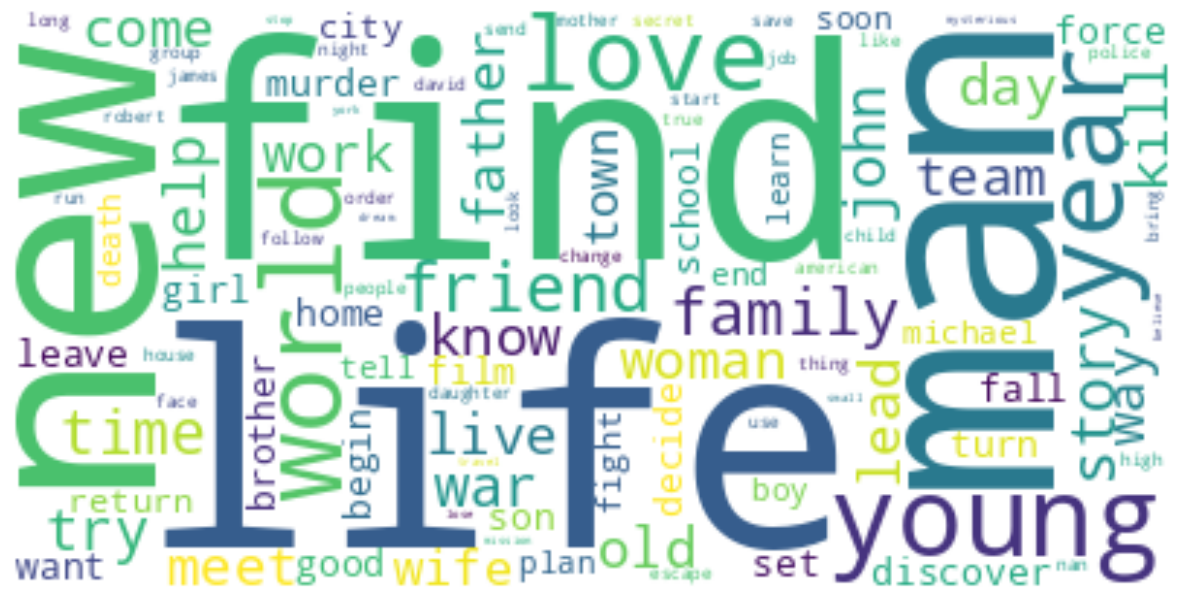

In [21]:
# visualizing frequency of words to describe the movies based on storyline and plot
series = pd.Series(np.concatenate(df_to_clean['all_text_tokenized'])).value_counts()[:100]
wordcloud = WordCloud(background_color='white').generate_from_frequencies(series)

plt.figure(figsize=(15,15), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Keeping a threshold for a better corpus

I set a frequency threshold to filter out words that occur too frequently. This is often done to reduce the dimensionality of the data and remove noisy terms

In [22]:
# Count word frequencies within each document and across all document

texts = df_to_clean['all_text_tokenized'].tolist()
dictionary = corpora.Dictionary(texts)

# Initialize dictionaries to store word frequencies
word_frequency_across_all_documents = defaultdict(int)
word_frequency_within_document = {}
key = 0

# Iterate through each document's words
for text in texts:
    # Count word frequencies within each document
    word_frequency_doc = defaultdict(int)
    for word in text:
        word_frequency_doc[word] += 1
    word_frequency_within_document[key] = word_frequency_doc
    key += 1

    # building the total word frequency across all documents
    for word, freq in word_frequency_doc.items():
        word_frequency_across_all_documents[word] += freq

In [23]:
# getting average of word frequencies across all documents
mean_across = sum(word_frequency_across_all_documents.values())/len(word_frequency_across_all_documents.values())
mean_across

9.903625398747293

### Word frequency plot

We have this plot to get a general idea on which threshold to use

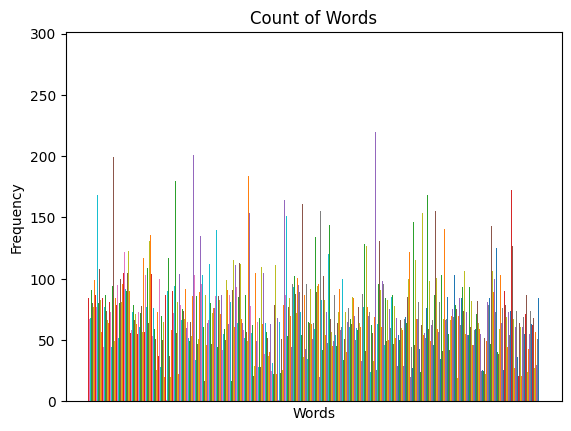

In [24]:
# Plotting frequency of word to approximate the threshhold in the next step
plt.hist(texts, bins=1)
plt.xticks([])
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Count of Words')
plt.show()

In [25]:
# filtering for all words that exceed a threshold within and across all documents for a better representative corpus
for doc in df_to_clean['all_text_tokenized']:
    for word in doc:
        current_count = doc.count(word)
        if(len(word) <= 2):
            doc.remove(word)
            pass
        if (current_count >= 1 and word_frequency_across_all_documents[word] <= 70):
            pass
        else:
            doc.remove(word)


In [26]:
# getting the bag of words data which contains the id and frequency for all words/token

dictionary = corpora.Dictionary(df_to_clean['all_text_tokenized'])
corpus = [dictionary.doc2bow(desc) for desc in df_to_clean['all_text_tokenized']]

`TF-IDF (Term Frequency-Inverse Document Frequency)` and `LSI (Latent Semantic Indexing)` are two techniques used in natural language processing and information retrieval to represent and analyze text documents. They serve different purposes and are often used in conjunction to improve the performance of various text-related tasks such as document retrieval, document clustering, and topic modeling. In our project we are using it to topic modelling

## TF-IDF (Term Frequency-Inverse Document Frequency):

`Term Frequency (TF)`: This component measures the frequency of a term (word) within a document. It reflects how often a word appears in a document. It is calculated as the number of times a term occurs in a document divided by the total number of terms in that document.

`Inverse Document Frequency (IDF)`: This component measures the importance of a term in the entire corpus (collection of documents). It is calculated as the logarithm of the total number of documents divided by the number of documents containing the term. Terms that are common across many documents receive a lower IDF score, while terms that are rare receive a higher score.

`TF-IDF Score`: The TF-IDF score for a term in a document is calculated by multiplying its TF and IDF values. This score is used to represent the importance of a term within a specific document relative to its importance in the entire corpus.

`Purpose`: TF-IDF is primarily used for document retrieval and ranking. It helps identify the most relevant documents for a given query by assigning higher scores to documents that contain query terms that are both frequent in the document (high TF) and relatively rare in the corpus (high IDF).

## LSI (Latent Semantic Indexing):

`LSI Transformation`: LSI is a technique used for dimensionality reduction and capturing latent semantic information in a document-term matrix. It employs singular value decomposition (SVD) to transform the original high-dimensional term-document matrix into a lower-dimensional representation.

`Semantic Space`: The resulting lower-dimensional space is often referred to as the "semantic space." In this space, terms and documents are represented as vectors, and the similarity between terms and documents can be measured using vector operations like cosine similarity.

`Purpose`: LSI is used for various text analysis tasks, including document clustering, information retrieval, and topic modeling. It helps overcome some of the limitations of traditional keyword-based methods like TF-IDF by capturing semantic relationships between terms and documents. LSI can reveal hidden patterns and associations in textual data.

`Topic Modeling`: LSI is also used for topic modeling, where it can identify topics or themes in a collection of documents by examining the patterns of term co-occurrence in the semantic space.

In [27]:
# developing the tf-idf and lsi model using the corpus data

movie_tfidf_model = gensim.models.TfidfModel(corpus, id2word = dictionary)
movie_lsi_model = gensim.models.LsiModel(
    movie_tfidf_model[corpus], id2word = dictionary, num_topics = 300)

In [28]:
# serializing and storing the corpus data for easy retrieval

gensim.corpora.MmCorpus.serialize('movie_tfidf_model_mm', movie_tfidf_model[corpus])
gensim.corpora.MmCorpus.serialize('movie_lsi_model_mm',movie_lsi_model[movie_tfidf_model[corpus]])

movie_tfidf_corpus = gensim.corpora.MmCorpus('movie_tfidf_model_mm')
movie_lsi_corpus = gensim.corpora.MmCorpus('movie_lsi_model_mm')

print(movie_tfidf_corpus)
print(movie_lsi_corpus)

movie_index = MatrixSimilarity(movie_lsi_corpus, num_features = movie_lsi_corpus.num_terms)

MmCorpus(5798 documents, 42947 features, 239923 non-zero entries)
MmCorpus(5798 documents, 300 features, 1736699 non-zero entries)


In [29]:
def search_similar_movies(search_term):
    query_bow = dictionary.doc2bow(spacy_tokenizer(search_term))
    query_tfidf = movie_tfidf_model[query_bow]
    query_lsi = movie_lsi_model[query_tfidf]
    movie_index.num_best = 5
    movies_list = movie_index[query_lsi]
    movies_list.sort(key=itemgetter(1), reverse=True)
    movie_names = []

    for j, movie in enumerate(movies_list):
        movie_names.append (
            {
                'Relevance': round((movie[1] * 100),2),
                'Movie Title': df_to_clean['name'][movie[0]],
                'Movie Plot': df_to_clean['all_text'][movie[0]]
            }

        )
        if j == (movie_index.num_best-1):
            break

    return pd.DataFrame(movie_names, columns=['Relevance','Movie Title','Movie Plot'])

## Output

Here is the output with relevance score and movie title related to it. The higher the relevance the more closely the movie matches the input. Below the top most movie title “Catch Me If You Can” is surely related to the inputs.

In [30]:
search_similar_movies('forger lawyer pilot doctor dicaprio')

,Relevance,Movie Title,Movie Plot
0,60.79,Catch Me If You Can,"Steven Spielberg\n| \n eonardo DiCaprio, T..."
1,47.85,Red Tails,"Anthony Hemingway\n| \n Cuba Gooding Jr., ..."
2,40.81,Iron Eagle,"Sidney J. Furie\n| \n uis Gossett Jr., Jas..."
3,39.61,Air America,"Roger Spottiswoode\n| \n Mel Gibson, Rober..."
4,38.54,The Rocketeer,"Joe Johnston\n| \n Campbell, Jennifer Conn..."


In [34]:
import IPython
print(IPython.sys_info())

{'commit_hash': 'fcc71cc32',
 'commit_source': 'installation',
 'default_encoding': 'utf-8',
 'ipython_path': '/usr/local/lib/python3.10/dist-packages/IPython',
 'ipython_version': '7.34.0',
 'os_name': 'posix',
 'platform': 'Linux-5.15.120+-x86_64-with-glibc2.35',
 'sys_executable': '/usr/bin/python3',
 'sys_platform': 'linux',
 'sys_version': '3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]'}


## Conclusion

The NLP model has demonstrated its ability to understand and process user keywords. It showcases the capabilities of modern NLP techniques and also highlights the potential for AI to personalize the way we engage with movies. By analyzing  the director, the cast, and the general plot of top 500 movies across 23 genres the model has become adept at making accurate predictions, ensuring that the recommendations are both relevant and enjoyable.

Cinecipher just scratches the surface of what is possible with NLPs in the content optimization field, and future models could include other features such as user history data to create better content recommendations for the user. We are excited about the possibilities that lie ahead and remain committed to refining and expanding our system.


## Citations

https://medium.com/analytics-vidhya/semantic-search-engine-using-nlp-cec19e8cfa7e

https://www.imdb.com/?ref_=nv_home


